In [31]:
import findspark 
findspark.init()

In [32]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("pyspark_glm_explain").config("spark.sql.execution.arrow.enabled", "true").enableHiveSupport().getOrCreate()

In [33]:
import re
from typing import List
from itertools import chain
from pyspark.ml import Model
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer, OneHotEncoder

from transparency.spark.ohe.decoder import OneHotDecoder
from transparency.spark.prediction.explainer.glm import GLMExplainTransformer

import pandas as pd
import matplotlib.pyplot as plt

In [34]:
def get_glm_pipeline_stages(categorical_columns, continuous_columns, label_column, family="tweedie", link="identity",
                            variance_power=0.0, link_power=1.0) -> List:
    encoders = []
    for c in categorical_columns:
        indexer = StringIndexer(inputCol=c, outputCol=f"{c}_IDX")
        encoders.append(indexer)
        encoder = OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=f"{c}_OHE", dropLast=False)
        encoders.append(encoder)

    features_column = f"features_{label_column}"
    prediction_column = f"prediction_{label_column}"

    assembler = VectorAssembler(inputCols=[f"{c}_OHE" for c in categorical_columns] + continuous_columns,
                                outputCol=features_column)

    if family == 'tweedie':
        _model = GeneralizedLinearRegression(labelCol=label_column, featuresCol=features_column,
                                             predictionCol=prediction_column, family=family, linkPower=link_power,
                                             variancePower=variance_power)
    else:
        _model = GeneralizedLinearRegression(labelCol=label_column, featuresCol=features_column,
                                             predictionCol=prediction_column, family=family,
                                             link=link)

    stages: List = encoders + [assembler, _model]

    return stages

In [35]:
def get_feature_coefficients(spark_session: SparkSession, model: Model, prediction_df: DataFrame,
                             feature_column: str, ) -> DataFrame:
    ml_attributes = prediction_df.schema[feature_column].metadata["ml_attr"]["attrs"].values()
    attrs = sorted((attr["idx"], attr["name"]) for attr in (chain(*ml_attributes)))
    coefficients = [
        (idx, re.sub('[^0-9a-zA-Z]+', '_', name), name, float(model.coefficients[idx]))
        for
        idx, name
        in attrs]
    coefficients.append((-1, "Intercept", "Intercept", model.intercept))
    coefficients.sort(key=lambda x: x[3], reverse=True)
    coefficients_df: DataFrame = spark_session.createDataFrame(coefficients).toDF("Feature_Index",
                                                                                  "Feature",
                                                                                  "Original_Feature",
                                                                                  "Coefficient")

    return coefficients_df

In [36]:
def resolve_link_function(family: str, link: str, link_power=1.0):
    _link_types = {"log": "logLink", "sqrt": "powerHalfLink", "identity": "identityLink",
                   "logit": "logitLink", "inverse": "inverseLink", "other": "otherPowerLink"}
    if 'tweedie' == family:
        return _link_types[{0.0: "log", 0.5: "sqrt", 1.0: "identity", -1.0: "inverse"}.get(link_power, "other")]
    else:
        return _link_types[link]

In [37]:
def get_glm_explain_stages(predictions_view: str, coefficients_view: str, label_column: str,
                           family: str = 'tweedie', link: str = 'identity',
                           variance_power: float = 0.0, link_power: float = 1.0) -> List:
    link_function_type = resolve_link_function(family, link, link_power)
    stages = [
        OneHotDecoder(oheSuffix="_OHE", idxSuffix="_IDX", unknownSuffix="Unknown"),
        SQLTransformer(statement=f"CREATE OR REPLACE TEMPORARY VIEW {predictions_view} AS SELECT * from __THIS__"),
        GLMExplainTransformer(predictionView=predictions_view, coefficientView=coefficients_view,
                              linkFunctionType=link_function_type, label=label_column, nested=True,
                              calculateSum=True, family=family, variancePower=variance_power, linkPower=link_power
                              )
    ]
    return stages

# GeneralizedLinearRegression

- The example below is using **boston dataset** for preciting the **median home prices** for occupied homes.
- The example is stricitly used for **demonstrating** the uagae of `GLMExplainTransformer`.

In [38]:
boston_csv = '/work/tests/data/regression/dataset_boston.csv'
boston_df: DataFrame = spark.read.option("header", True).option("inferSchema", True).csv(boston_csv)

In [39]:
label_column = 'medv'
features_column = f"features_{label_column}"
prediction_column = f"prediction_{label_column}"

contrib_column = f"prediction_{label_column}_contrib"
contrib_column_sum = f"{contrib_column}_sum"
contrib_column_intercept = f"{contrib_column}_intercept"

features_coefficient_view = f"features_coefficient_{label_column}_view"
predictions_view = f"predictions_{label_column}_view"

In [40]:
categorical_columns=[]
continuous_columns = [x for x in boston_df.columns if x not in ['id', label_column]]

In [41]:
stages = get_glm_pipeline_stages([], continuous_columns + categorical_columns, label_column,family="gaussian", link="log")

In [42]:
import uuid
pipeline = Pipeline(stages=stages)
pipeline_model: PipelineModel = pipeline.fit(boston_df)
glm_model = pipeline_model.stages[-1]
string_id = uuid.uuid4()
glm_model_path: str = f"/tmp/{string_id}"
glm_model.write().save(glm_model_path)

In [43]:
prediction_df = pipeline_model.transform(boston_df)
prediction_df.createOrReplaceTempView(predictions_view)

In [44]:
features_coefficients_df = get_feature_coefficients(spark, glm_model, prediction_df, features_column)
features_coefficients_df.createOrReplaceTempView(features_coefficient_view)

In [45]:
features_coefficients_df.show()

+-------------+---------+----------------+--------------------+
|Feature_Index|  Feature|Original_Feature|         Coefficient|
+-------------+---------+----------------+--------------------+
|           -1|Intercept|       Intercept|  3.5934179294150237|
|            5|       rm|              rm| 0.14297146250097179|
|            3|     chas|            chas| 0.06606567346006308|
|            8|      rad|             rad| 0.01568489582001018|
|            2|    indus|           indus| 0.00312300114663444|
|            1|       zn|              zn|9.853163534174047E-4|
|           11|    black|           black|5.189852722299955E-4|
|            6|      age|             age|4.438128429448265...|
|            9|      tax|             tax|-5.04566030374328...|
|            0|     crim|            crim|-0.00918445383815...|
|           12|    lstat|           lstat|-0.03466252972714503|
|           10|  ptratio|         ptratio|-0.03482239880119...|
|            7|      dis|             di

In [46]:
explain_stages = get_glm_explain_stages(predictions_view, features_coefficient_view, label_column, family="gaussian", link="log")
explain_pipeline = Pipeline(stages=explain_stages)
explain_df = explain_pipeline.fit(prediction_df).transform(prediction_df)

In [47]:
feature_index_meta = features_coefficients_df.select("Feature_Index", "Feature").filter("Feature_Index!=-1").orderBy("Feature_Index").rdd.collectAsMap()

In [48]:
expressions = []
for key,value in feature_index_meta.items():
    expressions.append(f"AVG({contrib_column}[{key}]) as {value}")

contributions = explain_df.selectExpr(expressions).collect()[0].asDict()

In [49]:
plot_contrib_df = pd.DataFrame.from_dict(contributions,orient='index',columns=['Contributions'])
plot_contrib_df.head()

,Contributions
crim,-1.190116
zn,0.513555
indus,1.528219
chas,0.218917
nox,-14.390360


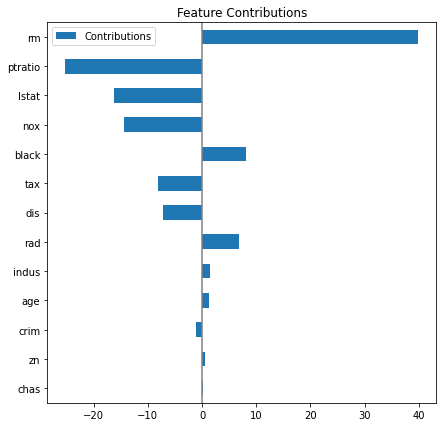

In [50]:
final_plot_contrib_df = plot_contrib_df.iloc[plot_contrib_df['Contributions'].abs().argsort()]
final_plot_contrib_df.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Contributions')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

 # GeneralizedLinearRegression : binomial/logit : classification
- The example below is using **prima india diabetes dataset** for preciting the **diabetes outcome** for patient.
- The example is stricitly used for **demonstrating** the uagae of `GLMExplainTransformer`.

In [51]:
prima_indian_diabetes_csv = '/work/tests/data/classification/dataset_prima_indian_diabetes.csv'
prima_indian_diabetes_df = spark.read.option("header", True).option("inferSchema", True).csv(
    prima_indian_diabetes_csv)

In [52]:
label_column = 'outcome'
features_column = f"features_{label_column}"
prediction_column = f"prediction_{label_column}"

contrib_column = f"prediction_{label_column}_contrib"
contrib_column_sum = f"{contrib_column}_sum"
contrib_column_intercept = f"{contrib_column}_intercept"

features_coefficient_view = f"features_importance_{label_column}_view"
predictions_view = f"predictions_{label_column}_view"

In [53]:
categorical_columns=[]
continuous_columns = [x for x in prima_indian_diabetes_df.columns if x not in ['id', label_column]]

In [54]:
stages = get_glm_pipeline_stages([], continuous_columns + categorical_columns, label_column,family="binomial", link="logit")

In [55]:
import uuid
pipeline = Pipeline(stages=stages)
pipeline_model: PipelineModel = pipeline.fit(prima_indian_diabetes_df)
glm_model = pipeline_model.stages[-1]
string_id = uuid.uuid4()
glm_model_path: str = f"/tmp/{string_id}"
glm_model.write().save(glm_model_path)

In [56]:
prediction_df = pipeline_model.transform(prima_indian_diabetes_df)
prediction_df.createOrReplaceTempView(predictions_view)

In [57]:
features_coefficients_df = get_feature_coefficients(spark, glm_model, prediction_df, features_column)
features_coefficients_df.createOrReplaceTempView(features_coefficient_view)

In [58]:
features_coefficients_df.show()

+-------------+--------------------+--------------------+--------------------+
|Feature_Index|             Feature|    Original_Feature|         Coefficient|
+-------------+--------------------+--------------------+--------------------+
|            6|diabetes_pedigree...|diabetes_pedigree...|  0.9451797406211632|
|            0|         pregnancies|         pregnancies| 0.12318229835242865|
|            5|                 bmi|                 bmi| 0.08970097003094403|
|            1|             glucose|             glucose|0.035163714606853205|
|            7|                 age|                 age| 0.01486900474447571|
|            3|      skin_thickness|      skin_thickness|6.189643648752055E-4|
|            4|             insulin|             insulin|-0.00119169898416...|
|            2|      blood_pressure|      blood_pressure|-0.01329554690430...|
|           -1|           Intercept|           Intercept|  -8.404696366913944|
+-------------+--------------------+----------------

In [59]:
explain_stages = get_glm_explain_stages(predictions_view, features_coefficient_view, label_column, family="binomial", link="logit")
explain_pipeline = Pipeline(stages=explain_stages)
explain_df = explain_pipeline.fit(prediction_df).transform(prediction_df)

In [60]:
feature_index_meta = features_coefficients_df.select("Feature_Index", "Feature").filter("Feature_Index!=-1").orderBy("Feature_Index").rdd.collectAsMap()

In [61]:
expressions = []
for key,value in feature_index_meta.items():
    expressions.append(f"AVG({contrib_column}[{key}]) as {value}")

contributions = explain_df.selectExpr(expressions).collect()[0].asDict()

In [62]:
plot_contrib_df = pd.DataFrame.from_dict(contributions,orient='index',columns=['Contributions'])
plot_contrib_df.head()

,Contributions
pregnancies,0.025666
glucose,0.217186
blood_pressure,-0.075511
skin_thickness,0.000622
insulin,-0.008005


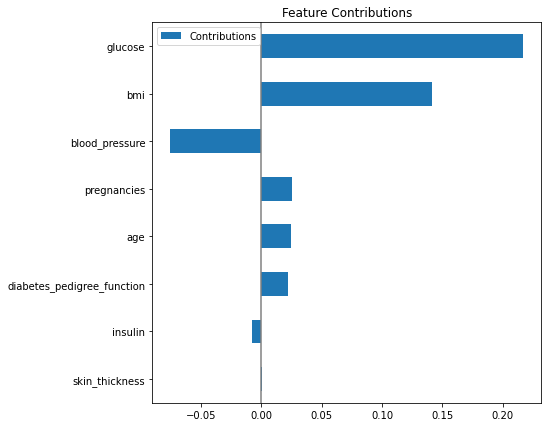

In [63]:
final_plot_contrib_df = plot_contrib_df.iloc[plot_contrib_df['Contributions'].abs().argsort()]
final_plot_contrib_df.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Contributions')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)